In the model there are two free parameters.  $X$ is exogenous to the agent while a is specific to the agent.  Each agent $i$ is initilized with a value for its a parameter $a_i$ and a set of network conncetions $c_i$.  






















In each period the true value of $X$ is a linear function of the previous period's X value and the average value of $a$ across all agents.  

$$
X_t = X_{t-1} + w_1 \frac{1}{N} \sum_{i=1}^N a_{i,t}
$$

Agent's expression of $a_i$ is inversely related to the relative levels of $X$ and $k$, where $k$ is some constant.  Agents use a simple updating rule to chose their level of a in each period.  
$$
a_{i} = a_{i,t-1} - w_2(\hat{X_i} - k)
$$

where $\hat{X}$ (which can be thought of a $\mathbb{E}_i[X]$) is estimated with an adaptive expectations rule that incorporates social knowledge.

$$
    \hat{X}_{i}  = \hat{X}_{i,t-1} + w_1\ f(\{a \in c_i\})
$$
and the function $f(\{a \in c_i\})$ represents some aggregation rule across the $a$ values of all connected agents.

The parameters have the following intepertations:
$$
\begin{align}
& X: \text{ A systemic, society level variable }  \\
& a: \text{  A propensity for some agent-level behavior} \\ 
& w1: \text{ The amount by which today's level of }a \text{ affects the systemic variable X} \\
& w2: \text{  The amount by which today's level of }X \text{ decreases }a_i\text{, the propensity for agent-behavior} \\
& k: \text{ The level of X at which the agent would neither increase nor decrease her propensity for some behavior} 
\end{align}
$$

So, to make a concrete example, we can map these variables into a model of the credit cycle  \begin{align}
& X: \text{ Average lending risk (across the entire universe of agents)}  \\
& a_i: \text{ Agent's propensity to lend} \\ 
& w1: \text{ The amount by which today's level of lending} \text{ affects the systemic lending risk X} \\
& w2: \text{  The amount by which today's lending risk }X \text{ affects }a_i\text{ agent's propensity to lend} \\
& k: \text{ The level of risk at which the agent would neither increase nor decrease her propensity to lend} 
\end{align} 

In [249]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as plb
import scipy as sp

from copy import copy
from math import log1p
from operator import attrgetter
from random import shuffle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf


class Agent(object):
    '''
    defines the attributes and behavior (methods) for each agent
    
    also includes a set of objects to collect data / track parameters in each period
    '''
    def __init__(self, id, parameters,model): #function called when each agent is initialized
        
        #--initialize the agent's attributes that will be used to store info in the simulation--#
        self.id = id #get an id number
        self.model = model #get the model obejct so it can be referenced
        self.mimic = False #set default (agents cannot mimic others)
        self.sigChoice = None #create an empty variable to represent the agents signal choice
        self.sigAvalEst = None #create an empty variable to represent the agent's perceived value
        self.connections = model.environment.neighbors(id) # figure out which agents are connected
        for k,v in parameters.items(): #loop through all keyword arguments
            setattr(self,k,v) #assign the kwargs as object attributes
        #---------------------------------------------------------------------------------------#
        
        self.q = np.random.normal(self.q_mean,self.q_sigma) #determine agent's quality
        
        #create an indicator of which signals the agent can afford
        self.sigAfford = {'a':self.q>=self.sigAcost,'b':self.q>=4,'c':self.q>=2,'n':True}
        
        '''--------Tracking / Data collection objects (not used for simulation purposes)------'''
        self.sigChoices = [self.sigChoice] #list to track choice of signal
        self.sigAvalues = [self.sigAval] #list to track perception of signal A value
        self.estimatesA = [None] #list to track estimates of signal A value
        self.neighborsA = [None] #list to track how many neighbors display signal A
        self.mimicing   = [None] #list tracking if the agent was mimicing in the period
        '''-----------------------------------------------------------------------------------'''
        
        self.determineSig() #determine the initial signal the agent will display
        
        self.updateChoices() #finalize and track signal choice (after tracking objects initiated)
        
    def step(self): #calculate the results for this period 
        
        #determine whether this agent can mimic 
        self.mimic = random.random() < self.m
        
        #update agent's beliefs about each signal's value
        self.updateBelief()
        
        #choose the signal to display
        self.determineSig()
        
    
    def updateBelief(self): #update the agents perception of the value of each signal
        
        neighborList = [] #create an empty list to track neighbors who are displaying signal A
        
        #check which neighbors are displaying signal A
        sigAq = [] #create an empty list to hold info about neighbors who are signaling
        
        for n in self.connections: #for each neighbor
            if self.model.agents[n].sigChoice == 'a': #if the neighbor displayes signal A
                sigAq.append(copy(self.model.agents[n].q)) #collect the neighbors value
                neighborList.append(n) #keep track of which neighbors signal A 
            if self.sigChoice == 'a': #if the agent is displaying the signal
                sigAq.append(copy(self.model.agents[n].q)) #include the agents own quality 
        if sigAq is None:
            sigAq = sigAval
        
        '''-----------Keep track of which neighbors displayed signal A in the period---------'''
        self.neighborsA.append(neighborList) #append this period's data to the tracking list
        '''----------------------------------------------------------------------------------'''
        
        #caculate the agents estimate of the signal value this period
        '''
        The estimate of the value combines 
            1) the true cost of the signal 
            2) the quality of observable agents displaying the signal
            3) the quality of the agent displaying the signal
        
        The logic behind this is fully described in the mathematical description.
        The weight given to the "true" value of the signal is based on its prevalence
        '''
        
        self.sigAvalEst = (sum(sigAq) + self.sigAcost) / (len(sigAq) + 1) 
        
        #use this calculation to update the signal value of A
        self.sigAval = (1-self.w)*self.sigAval + self.w*self.sigAvalEst
        
        
    def determineSig(self):
        #use the new signal value of the A to decide whether to determine display the signal.
        '''
        The basic steps of determining which signal to adopt are:
        1) calcualte which is the prefered (best) signal (i.e. the signal the agent believes has the highest value)
        2) check if the agent can afford the signal or can mimic
        3) if the agent cannot afford the signal, exclude the signal and repeat 1) and 2) 
        
        #---(eventually would like to extend this so other signal values can vary too)---#

        '''
        
        signalValues = {'a':self.sigAval,'b':2,'c':1,'n':0} #collect the current singal value for each signal
        signalFound = False #set up a tracker indicating whether an affordable signal was found
        while not signalFound:
            prefSignal = max(signalValues.keys(), key=(lambda k: signalValues[k])) #determine the "best" signal
            
            #determine if the currenet prefered signal can be used
            '''
            The prefered signal can be used when one of the following conditions is met
            1) The agent can "afford" the signal
            2) The agent can mimic signals in this period and can observe a signal to mimic
            3) The agent "know how" to display (since they are already displaying the prefered signal)
            '''
            if self.sigAfford[prefSignal] or (self.mimic and self.neighborsA) or (self.sigChoice == prefSignal): 
                self.newSigChoice = prefSignal #agent chooses to display the current prefered signal
                signalFound = True #change tracker to true (will continue processing)
            else: #if the prefered signal is not affordable
                del signalValues[prefSignal] #remove it from the list of signal options and repeat
           
    def updateChoices(self):
        self.sigChoice = self.newSigChoice

        '''-------------------------track values of agent's parameters----------------------'''
        self.sigChoices.append(copy(self.sigChoice))
        self.sigAvalues.append(copy(self.sigAval))
        self.estimatesA.append(copy(self.sigAvalEst))
        self.mimicing.append(copy(self.mimic))
        '''---------------------------------------------------------------------------------'''

        
class model(object): #define a model
    '''
    Define the environment and the simulation structure
    Network: Watts Strogatz Small World Graph
    Simulation Pattern: Each Agent is "Activated" in sequential order
    Periods: The model takes a fixed input that determines the number of periods it runs for
    '''
    def __init__(self,parameters): #define the steps taken at initiation of a model
        self.N = parameters['N']
        #In this model, I use a small world Watts Strogatz network
        self.environment = nx.watts_strogatz_graph(self.N,parameters['k'],parameters['p']) #N nodes, K neighbors connected, .25 probability of rewireing
        self.agents = [] #make an empty list to hold agents
        for i in range(self.N): #Loop through each agent
            agent = Agent(i,parameters,self) #ceate the agent
            self.agents.append(agent) #add the agent to the list of agents
        
        
        '''Create a set of objects to track parameters and other metrics at the system level'''
        self.averageAval = []
        self.averageQval = []
        self.sigCounts   = []
        
        self.sigAcount   = 0
        self.sigBcount   = 0
        self.sigCcount   = 0
        self.aValues     = []
        self.qValues     = []

        '''---------------------------------------------------------------------------------'''
        
    def step(self,periods): #run the entire model for a designated number of periods

        #begin simulation
        
        for p in range(periods): #period loop
            
            shuffle(self.agents) #randomize order of agents
            for a in self.agents: #loop through all agents
                a.step() #activate the agent's behavior for the period
                
                '''-------------Track values of A and Q---------------'''
                self.aValues.append(a.sigAval)
                
                
                '''-------------Track signal choices------------------'''
                if a.sigChoice == 'a':
                    self.sigAcount += 1
                    ''' Track Q values of agents displaying A'''
                    self.qValues.append(a.q) 
                if a.sigChoice == 'b':
                    self.sigBcount += 1
                if a.sigChoice == 'c':
                    self.sigCcount += 1
                '''---------------------------------------------------'''
            
            for a in self.agents: #loop back through each agent
                a.updateChoices() #update values that only change at the end of the period
            
            self.sigCounts.append([self.sigAcount,self.sigBcount,self.sigCcount])
            
            
            
            self.averageAval.append(sum(self.aValues)/len(self.aValues))
            if self.sigAcount > 0:
                self.averageQval.append(sum(self.qValues)/self.sigAcount)
            else:
                self.averageQval.append(0)
                
                
            self.sigAcount = 0
            self.sigBcount = 0
            self.sigCcount = 0
            self.aValues = [] #reset the list that tracks each agents belief about signal A
            self.qValues = [] #reset the list that tracks each agent's (displaying A) quality
            
            
    def getPeriod(self):
        
        W    = np.fft.fft(X)
        freq = np.fft.fftfreq(N,1)
            
    def showNetwork(self):
        b = nx.draw_networkx(self.environment)
        plt.show()
        
    def showTrends(self,smooth=False,autoCor=False):
        
        smooth = lambda x: list(pd.rolling_mean(pd.Series(x),5).values)[5:]
        plotObj  = [self.averageAval,self.averageQval,[a[0] for a in self.sigCounts],self.agents[1].sigAvalues]
        labels   = ['Avg Perceived Value of Signal A','Avg Quality of Agents signaling A','Agents Signaling A','Agent 1 signal A Values']
        
        if smooth:
            plotObj = [smooth(o) for o in plotObj]
        
        
        for i in range(len(plotObj)):
            
            if autoCor:
                plot_acf(plotObj[i], label=labels[i]+'test')
                plt.xlim([0,25])
                plt.legend([labels[i]], loc='upper right', fontsize = 'small')
                plt.show()
            else:
                Line, = plt.plot(plotObj[i], label=labels[i])
                plt.legend(handles=([Line]))
                plt.show()
           
        
    def reportStatistics(self):
        pass
    
        for vec in obj:
            avg = sum(vec) / len(vec)
            std = np.std(vec)
            rng = max(vec) - min(vec)
            acorr = acf(vec,alpha=.05)
            aCorrL5  = (acorr[0][5],bool(acorr[1][5][0] < 0 < acorr[1][5][1]))
            aCorrL10 = (acorr[0][10],bool(acorr[1][10][0] < 0 < acorr[1][10][1]))
            aCorrL15 = (acorr[0][15],bool(acorr[1][15][0] < 0 < acorr[1][15][1]))
    
        
        #to be reported: a vector with averages, std dev, range, autocorrelation, period

In [247]:
params = {'q_mean':.5,
          'q_sigma':.5,
          'sigAcost':3,
          'sigAval':3,
          'k':4,
          'p':0,
          'w':.3,
          'm':.1,
          'N':100
         }
test = model(params)

In [267]:
test.step(400)
t = acf([a[0] for a in test.sigCounts],alpha=.05)
(t[1][5][0])< 0 < (t[1][5][1])
#test.showTrends(autoCor = True)
#test.showTrends(smooth=True)
#test.agents[0].sigAval
#test.testlist
#test.testlist
#test.agents[1].connections
#test.agents[99].siglsit
#test.agents[1].mimic

True

In [242]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

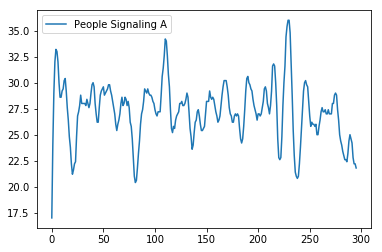

In [38]:
import matplotlib
#test.step(300)
#aLine, = plt.plot(test.averageAval, label='Value of Signal')
XLine,  = plt.plot(running_mean([a[0] for a in test.sigCounts],5), label='People Signaling A')
#bLine, = plt.plot(test.agents[1].sigAvalues, label='Value of Signal for Agent')
plt.legend(handles=([XLine]))
plt.show()


In [16]:
def decision(probability):
    return random.random() < probability

In [163]:
tt =pd.rolling_mean(pd.Series([1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10]),3)
ta = list(tt.values)
ta[2:]

/home/alex/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.


[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 6.666666666666667,
 4.333333333333333,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 6.666666666666667,
 4.333333333333333,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0]

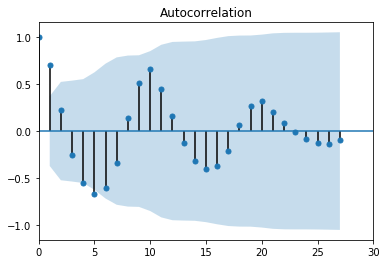

In [164]:
t = [1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10]
plot_acf(ta[2:],fft=False)
plt.xlim([0, 30])
plt.show()
